
# Part 3: Putting it all together: Compile, Quantize and Deploy

In this Part of the lab, we will review what we learned in Parts 1 and 2, and deploy models to be accelerated on the FPGA. We will look at each step of the deployment process. 

Once you have the outputs of the compiler and quantizer, you will use the xfDNN deployment APIs to:
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run fully connected layers on the CPU
7. Run Softmax on CPU
8. Print the result (or send the result for further processing)
9. When you are done, close the handle to the FPGA

First, we will look at compiling, quantizing and deploying a Inception v1 image classification example. After completing the example, we will look at deploying a customer model, using the same steps. 

### 1. Import required packages, check environment

In [2]:
import os,sys,cv2
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

# Bring in Xilinx ML-Suite Compiler, Quantizer, PyXDNN
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe import CaffeFrontend as xfdnnCompiler
from xfdnn.tools.quantize.quantize import CaffeFrontend as xfdnnQuantizer
import xfdnn.rt.xdnn as pyxfdnn
import xfdnn.rt.xdnn_io as pyxfdnn_io

import warnings
warnings.simplefilter("ignore", UserWarning)

print("Current working directory: %s" % os.getcwd())
print("Running on host: %s" % os.uname()[1])
print("Running w/ LD_LIBRARY_PATH: %s" %  os.environ["LD_LIBRARY_PATH"])
print("Running w/ XILINX_OPENCL: %s" %  os.environ["XILINX_OPENCL"])
print("Running w/ XCLBIN_PATH: %s" %  os.environ["XCLBIN_PATH"])
print("Running w/ PYTHONPATH: %s" %  os.environ["PYTHONPATH"])
print("Running w/ SDACCEL_INI_PATH: %s" %  os.environ["SDACCEL_INI_PATH"])

!whoami
# Make sure there is no error in this cell
# The xfDNN runtime depends upon the above environment variables

Current working directory: /home/centos/MLsuite/notebooks
Running on host: ip-172-31-57-221.ec2.internal
Running w/ LD_LIBRARY_PATH: /home/centos/MLsuite/overlaybins/aws/runtime/lib/x86_64/:/home/centos/MLsuite/xfdnn/rt/xdnn_cpp/build/lib:/home/centos/MLsuite/xfdnn/rt/lib:/home/centos/MLsuite/ext/boost/lib:/root
Running w/ XILINX_OPENCL: /home/centos/MLsuite/overlaybins/aws
Running w/ XCLBIN_PATH: /home/centos/MLsuite/overlaybins/aws
Running w/ PYTHONPATH: /home/centos/MLsuite:/home/centos/MLsuite/xfdnn/rt:/home/centos/MLsuite/xfdnn/tools/emu
Running w/ SDACCEL_INI_PATH: /home/centos/MLsuite/overlaybins
root


### 2. Use a config dictionary to pass parameters

Similar to Parts 1 and 2, we will setup and use a config dictionary to simplify handing the arguments. In this cell, we will also perform some basic error checking. For this first example, we will attempt to classify a picture of a dog. 


Runnning on Amazon AWS EC2


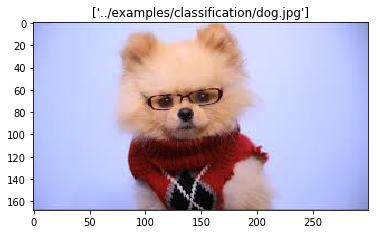

In [4]:
config = {}

# Quick check to see if we are running on AWS, if not assume 1525 box
if os.path.exists("/sys/hypervisor/uuid"):
    with open("/sys/hypervisor/uuid") as fp:
        contents = fp.read()
        if "ec2" in contents:
            print("Runnning on Amazon AWS EC2")
            config["device"] = "aws"
else:
    print("Runnning on VCU1525")
    config["device"] = "1525"


config["images"] = ["../examples/classification/dog.jpg"] # Image of interest (Must provide as a list)

img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(config["images"])
plt.show()

### 3. Compile The Model

As in Part 1, we will use the xfDNN Compiler to compile the Inception v1 network defined in Caffe. Please refer to the parameter descriptions in Part 1 for guidance on these parameters. 


In [7]:
# Compiler Arguments

config["prototxt"] = "../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_deploy.prototxt" 
config["caffemodel"] = "../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn.caffemodel"
config["outmodel"] = "work/optimized_model" # String for naming optimized prototxt, caffemodel
config["fpgacommands"] = "work/fpga.cmds" # Compiler will generate FPGA instructions
config["memory"] = 5 # Available on-chip SRAM
config["dsp"] = 56 # Width of Systolic Array
config["ddr"] = 256 # Available off-chip DRAM

compiler = xfdnnCompiler(
    networkfile=config["prototxt"],       # Prototxt filename: input file
    weights=config["caffemodel"],         # Floating Point Weights: input file
    anew=config["outmodel"],              # String for intermediate prototxt/caffemodel
    generatefile=config["fpgacommands"],  # Script filename: output file
    memory=config["memory"],              # Available on chip SRAM within xclbin
    dsp=config["dsp"],                    # Rows in DSP systolic array within xclbin 
    ddr=config["ddr"]                     # Memory to allocate in FPGA DRAM for activation spill
)

# Invoke compiler
try:
    compiler.compile()

    # The compiler extracts the floating point weights from the .caffemodel. 
    # This weights dir will be stored in the work dir with the appendex '_data'. 
    # The compiler will name it after the caffemodel, and append _data
    config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data"
        
    if os.path.exists(config["datadir"]) and os.path.exists(config["fpgacommands"]+".json"):
        print("Compiler successfully generated JSON and the data directory: %s" % config["datadir"])
    else:
        print("Compiler failed to generate the JSON or data directory: %s" % config["datadir"])
        raise
        
    print("**********\nCompilation Successful!\n")
    
    import json
    data = json.loads(open(config["fpgacommands"]+".json").read())
    print("Network Operations Count: %d"%data['ops'])
    print("DDR Transfers (bytes): %d"%data['moveops']) 
    
except Exception as e:
    print("Failed to complete compilation:",e)


Network: ../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_deploy.prototxt
GenerateCode: work/fpga.cmds
Weights: ../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn.caffemodel
PngFile: None
ConcatStrategy: None
Strategy: all
ScheduleFile: None
DSP: 56
Verbose: False
FromTF: False
Memory: 5
DDR: 256
Phase: TEST
RankDir: BT

**************************************************
* BUILDING DATA FLOW GRAPH
**************************************************

**************************************************
* BUILDING NETWORK SCHEDULE
**************************************************
Network Schedule ['data', 'conv1/7x7_s2', 'conv1/relu_7x7', 'pool1/3x3_s2', 'conv2/3x3_reduce', 'conv2/relu_3x3_reduce', 'conv2/3x3', 'conv2/relu_3x3', 'pool2/3x3_s2', 'inception_3a/1x1', 'inception_3a/relu_1x1', 'inception_3a/3x3_reduce', 'inception_3a/relu_3x3_reduce', 'inception_3a/3x3', 'inception_3a/relu_3x3', 'inception_3a/5x5_reduce', 'inception_3a/relu_5x5_

### 4. Quantize The Model
As in Part 2, we will use the xfDNN Quantizer to quantize the Inception v1 model defined in Caffe. Please refer to the parameter descriptions in Part 2 for guidance on these parameters. 


In [10]:
# Quantizer Arguments
#config["outmodel"] = Defined in Step 1 # String for naming intermediate prototxt, caffemodel
config["quantizecfg"] = "work/quantization_params.json" # Quantizer will generate quantization params
config["bitwidths"] = [16,16,16] # Supported quantization precision
config["in_shape"] = [3,224,224] # Images will be resized to this shape -> Needs to match prototxt
config["transpose"] = [2,0,1] # Transpose argument to quantizer
config["channel_swap"] = [2,1,0] # Channel Swap argument to quantizer
config["raw_scale"] = 255.0
config["img_mean"] = [104.007, 116.669, 122.679] # Mean of the training set (From Imagenet)
config["input_scale"] = 1.0
config["calibration_size"] = 15 # Number of calibration images quantizer will use
config["calibration_directory"] = "../xfdnn/tools/quantize/calibration_directory" # Directory of images

quantizer = xfdnnQuantizer(
    deploy_model=config["outmodel"]+".prototxt",          # Prototxt filename: input file
    weights=config["outmodel"]+".caffemodel",             # Floating Point weights
    output_json=config["quantizecfg"],                    # Quantization filename: output file
    bitwidths=config["bitwidths"],                        # Fixed Point precision: 8b or 16b
    dims=config["in_shape"],                              # Image dimensions [Nc,Nw,Nh]
    transpose=config["transpose"],                        # Transpose argument to caffe transformer
    channel_swap=config["channel_swap"],                  # Channel swap argument to caffe transfomer
    raw_scale=config["raw_scale"],                        # Raw scale argument to caffe transformer
    mean_value=config["img_mean"],                        # Image mean per channel to caffe transformer
    input_scale=config["input_scale"],                    # Input scale argument to caffe transformer
    calibration_size=config["calibration_size"],          # Number of calibration images to use
    calibration_directory=config["calibration_directory"] # Directory containing calbration images
)

# Invoke quantizer
try:
    quantizer.quantize()

    import json
    data = json.loads(open(config["quantizecfg"]).read())
    print("**********\nSuccessfully produced quantization JSON file for %d layers.\n"%len(data['network']))
except Exception as e:
    print("Failed to quantize:",e)

Mean : [104.007 116.669 122.679]
Adding ../xfdnn/tools/quantize/calibration_directory/13923040300_b4c8521b4d_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/14931486720_37bd588ce9_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/15439525724_97d7cc2c81_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/16247716843_b419e8b111_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/3272651417_27976a64b3_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/3591612840_33710806df_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/36085792773_b9a3d115a3_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/4788821373_441cd29c9f_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/4814953542_de4b973dc2_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/cali

n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  2692.710205078125 , sf_layer_out:  0.0821775019097911
Threshold out shape= ()
n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  2692.710205078125 , sf_layer_out:  0.0821775019097911
bw_layer_in:  16
th_layer_in:  2234.35498046875
bw_layer_out:  16
th_layer_out:  2692.710205078125
--------------------------------------------------------------------------------
Processing layer 15 of 149
Layer Name:inception_3a/3x3_relu Type:ReLU
Inputs: ['inception_3a/3x3'], Outputs: ['inception_3a/3x3']
n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  2375.626708984375 , sf_layer_out:  0.07250058622957167
bw_layer_out:  16
th_layer_out:  2375.626708984375
--------------------------------------------------------------------------------
Processing layer 16 of 149
Layer Name:inception_3a/5x5_reduce Type:Convolution
Inputs: ['pool2/3x3_s2_pool2/3x3_s2_0_split_2'], Outputs: ['inception_3a/5x5_reduce']
Quantizing conv input layer ... incept

n:  32768 , len(bin_edges):  615
Mean : th_layer_out:  1639.0567626953125 , sf_layer_out:  0.05002156934401417
Threshold out shape= ()
n:  32768 , len(bin_edges):  615
Mean : th_layer_out:  1639.0567626953125 , sf_layer_out:  0.05002156934401417
bw_layer_in:  16
th_layer_in:  2375.626708984375
bw_layer_out:  16
th_layer_out:  1639.0567626953125
--------------------------------------------------------------------------------
Processing layer 32 of 149
Layer Name:inception_3b/5x5_reduce_relu Type:ReLU
Inputs: ['inception_3b/5x5_reduce'], Outputs: ['inception_3b/5x5_reduce']
n:  32768 , len(bin_edges):  615
Mean : th_layer_out:  1308.6343994140625 , sf_layer_out:  0.03993757131913396
bw_layer_out:  16
th_layer_out:  1308.6343994140625
--------------------------------------------------------------------------------
Processing layer 33 of 149
Layer Name:inception_3b/5x5 Type:Convolution
Inputs: ['inception_3b/5x5_reduce'], Outputs: ['inception_3b/5x5']
Quantizing conv input layer ... incept

Threshold in shape= ()
Quantizing conv weights for layer inception_4a/5x5_reduce...
Threshold params shape= (16,)
n:  32768 , len(bin_edges):  218
Mean : th_layer_out:  848.82861328125 , sf_layer_out:  0.025904984077921384
Threshold out shape= ()
n:  32768 , len(bin_edges):  218
Mean : th_layer_out:  848.82861328125 , sf_layer_out:  0.025904984077921384
bw_layer_in:  16
th_layer_in:  1525.1004638671875
bw_layer_out:  16
th_layer_out:  848.82861328125
--------------------------------------------------------------------------------
Processing layer 48 of 149
Layer Name:inception_4a/5x5_reduce_relu Type:ReLU
Inputs: ['inception_4a/5x5_reduce'], Outputs: ['inception_4a/5x5_reduce']
n:  32768 , len(bin_edges):  218
Mean : th_layer_out:  848.82861328125 , sf_layer_out:  0.025904984077921384
bw_layer_out:  16
th_layer_out:  848.82861328125
--------------------------------------------------------------------------------
Processing layer 49 of 149
Layer Name:inception_4a/5x5 Type:Convolution
In

n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  639.5220336914062 , sf_layer_out:  0.019517259245320176
bw_layer_in:  16
th_layer_in:  639.5220336914062
bw_layer_out:  16
th_layer_out:  639.5220336914062
--------------------------------------------------------------------------------
Processing layer 70 of 149
Layer Name:inception_4b/output_inception_4b/output_0_split Type:Split
Inputs: ['inception_4b/output'], Outputs: ['inception_4b/output_inception_4b/output_0_split_0', 'inception_4b/output_inception_4b/output_0_split_1', 'inception_4b/output_inception_4b/output_0_split_2', 'inception_4b/output_inception_4b/output_0_split_3']
bw_layer_in:  16
th_layer_in:  639.5220336914062
bw_layer_out:  16
th_layer_out:  639.5220336914062
--------------------------------------------------------------------------------
Processing layer 71 of 149
Layer Name:inception_4c/1x1 Type:Convolution
Inputs: ['inception_4b/output_inception_4b/output_0_split_0'], Outputs: ['inception_4c/1x1']
Quantizin

bw_layer_in:  16
th_layer_in:  317.74530029296875
bw_layer_out:  16
th_layer_out:  297.9419860839844
--------------------------------------------------------------------------------
Processing layer 91 of 149
Layer Name:inception_4d/3x3_relu Type:ReLU
Inputs: ['inception_4d/3x3'], Outputs: ['inception_4d/3x3']
n:  32768 , len(bin_edges):  922
Mean : th_layer_out:  260.753662109375 , sf_layer_out:  0.00795781310798593
bw_layer_out:  16
th_layer_out:  260.753662109375
--------------------------------------------------------------------------------
Processing layer 92 of 149
Layer Name:inception_4d/5x5_reduce Type:Convolution
Inputs: ['inception_4c/output_inception_4c/output_0_split_2'], Outputs: ['inception_4d/5x5_reduce']
Quantizing conv input layer ... inception_4d/5x5_reduce
Threshold in shape= ()
Quantizing conv weights for layer inception_4d/5x5_reduce...
Threshold params shape= (32,)
n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  352.7899475097656 , sf_layer_out:  0.0107666

n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  235.53150939941406 , sf_layer_out:  0.00718807060150194
Threshold out shape= ()
n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  235.53150939941406 , sf_layer_out:  0.00718807060150194
bw_layer_in:  16
th_layer_in:  373.7434387207031
bw_layer_out:  16
th_layer_out:  235.53150939941406
--------------------------------------------------------------------------------
Processing layer 108 of 149
Layer Name:inception_4e/5x5_reduce_relu Type:ReLU
Inputs: ['inception_4e/5x5_reduce'], Outputs: ['inception_4e/5x5_reduce']
n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  235.53150939941406 , sf_layer_out:  0.00718807060150194
bw_layer_out:  16
th_layer_out:  235.53150939941406
--------------------------------------------------------------------------------
Processing layer 109 of 149
Layer Name:inception_4e/5x5 Type:Convolution
Inputs: ['inception_4e/5x5_reduce'], Outputs: ['inception_4e/5x5']
Quantizing conv input layer ... ince

n:  32768 , len(bin_edges):  533
Mean : th_layer_out:  59.35868453979492 , sf_layer_out:  0.0018115385766104594
Threshold out shape= ()
n:  32768 , len(bin_edges):  533
Mean : th_layer_out:  59.35868453979492 , sf_layer_out:  0.0018115385766104594
bw_layer_in:  16
th_layer_in:  166.66395568847656
bw_layer_out:  16
th_layer_out:  59.35868453979492
--------------------------------------------------------------------------------
Processing layer 133 of 149
Layer Name:inception_5b/1x1_relu Type:ReLU
Inputs: ['inception_5b/1x1'], Outputs: ['inception_5b/1x1']
n:  32768 , len(bin_edges):  533
Mean : th_layer_out:  44.998348236083984 , sf_layer_out:  0.0013732825170471505
bw_layer_out:  16
th_layer_out:  44.998348236083984
--------------------------------------------------------------------------------
Processing layer 134 of 149
Layer Name:inception_5b/3x3_reduce Type:Convolution
Inputs: ['inception_5a/output_inception_5a/output_0_split_1'], Outputs: ['inception_5b/3x3_reduce']
Quantizing co

Arguments:
[('calibration_seed', None), ('mean_value', [104.007, 116.669, 122.679]), ('dims', [3, 224, 224]), ('calibration_indices', None), ('bitwidths', [16, 16, 16]), ('transpose', [2, 0, 1]), ('raw_scale', 255.0), ('calibration_size', 15), ('calibration_directory', '../xfdnn/tools/quantize/calibration_directory'), ('weights', 'work/optimized_model.caffemodel'), ('deploy_model', 'work/optimized_model.prototxt'), ('channel_swap', [2, 1, 0]), ('input_scale', 1.0), ('output_json', 'work/quantization_params.json')]
**********
Successfully produced quantization JSON file for 57 layers.



### 5. Deploy The Model
Next, we need to utilize the xfDNN APIs to deploy our network to the FPGA. We will walk through the deployment APIs, step by step: 
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run fully connected layers on the CPU
7. Run Softmax on CPU
8. Print the result (or send the result for further processing)
9. When you are done, close the handle to the FPGA

First, we will create the handle to communicate with the FPGA and choose which FPGA overlay to run the inference on. For this lab, we will use the `xdnn_56_16b_5m` overlay. You can learn about other overlay options in the ML Suite Tutorials [here][].  

[here]: https://github.com/Xilinx/ml-suite

In [14]:
# Create a handle with which to communicate to the FPGA
# The actual handle is managed by pyxfdnn

config["xclbin"] = "../overlaybins/" + config["device"] + "/xdnn_56_16b_5m.awsxclbin" # Chosen Hardware Overlay
## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
## Specifically, the DSP array width, and the memory arguments

config["xfdnn_library"] = "../xfdnn/rt/xdnn_cpp/lib/libxfdnn.so" # Library functions called by pyXFDNN

ret = pyxfdnn.createHandle(config['xclbin'], "kernelSxdnn_0", config['xfdnn_library'])
if ret:                                                             
    print("ERROR: Unable to create handle to FPGA")
else:
    print("INFO: Successfully created handle to FPGA")

INFO: Successfully created handle to FPGA


### 6. Apply quantization scaling and transfer model weights to the FPGA. 

In [26]:
# Quantize, and transfer the weights to FPGA DDR

# config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data" # From Compiler
config["scaleA"] = 10000 # Global scaler for weights (Must be defined, although not used)
config["scaleB"] = 30 # Global scaler for bias (Must be defined, although not used)
config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements

(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)

# Note that this function returns pointers to weights corresponding to the layers that will be implemented in the CPU

Loading weights/bias/quant_params to FPGA...


### 7. Allocate space in host memory for inputs, load images from disk, and prepare images. 

In [27]:
# Allocate space in host memory for inputs, Load images from disk

config["transform"] = "resize" # Resize Images to fit into network
config["firstfpgalayer"] = "conv1/7x7_s2" # Name of first layer to be ran on the FPGA -> Needs to match prototxt

(fpgaInputs, batch_sz) = pyxfdnn_io.prepareInput(config)

### 8. Allocate space in host memory for outputs

In [ ]:
# Allocate space in host memory for outputs

config["fpgaoutsz"] = 1024 # Number of elements in the activation of the last layer ran on the FPGA

fpgaOutputs = pyxfdnn_io.prepareOutput(config['fpgaoutsz'], batch_sz)

### 9. Write optimized micro-code to the xDNN Processing Engine on the FPGA. 

In [ ]:
# Write FPGA Instructions to FPGA and Execute the network!
if len(pyxfdnn._xdnnManager._handles) > 0: # Just make sure FPGA still available
    pyxfdnn.execute(
        config["fpgacommands"],
        weightsBlob,
        fpgaInputs,
        fpgaOutputs,
        batch_sz, # Number of images we are processing
        1, # Always leave this as 1
        config['quantizecfg'], 
        config['scaleB'], 
        config['PE']
    )

### 10. Execute the Fully Connected Layers on the CPU

In [ ]:
# Step 3.6
# Execute the Fully Connected Layers on the CPU
# The FPGA does not support fully connected layers
# Given they are very fast with BLAS in the CPU, we leave the final layers to be executed there

config["outsz"] = 1000 # Number of elements output by FC layers
config["useblas"] = True # Accelerate Fully Connected Layers in the CPU

if len(pyxfdnn._xdnnManager._handles) > 0: # Just make sure FPGA still available
    fcOut = pyxfdnn.computeFC(
        fcWeight, 
        fcBias, 
        fpgaOutputs,
        batch_sz, 
        config['outsz'], 
        config['fpgaoutsz'], 
        config['useblas'] # Can use cblas if True or numpy if False
    )

### 11. Execute the Softmax layers

In [36]:
# Compute the softmax to convert the output to a vector of probabilities
softmaxOut = pyxfdnn.computeSoftmax(fcOut, batch_sz)

### 12. Output the classification prediction scores



---------- Prediction 0 for ../examples/classification/dog.jpg ----------
0.0020 - "n02112018 Pomeranian"
0.0011 - "n02123394 Persian cat"
0.0010 - "n02085620 Chihuahua"
0.0010 - "n04399382 teddy, teddy bear"
0.0010 - "n02094433 Yorkshire terrier"



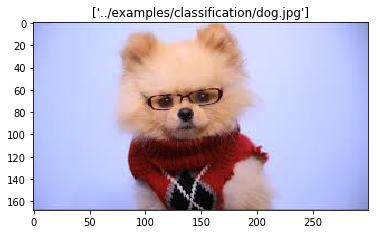

In [37]:
# Print the classification given the labels synset_words.txt (Imagenet classes)

config["labels"] = "../examples/classification/synset_words.txt"
pyxfdnn_io.printClassification(softmaxOut, config);

#Print Original Image for Reference 
img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(config["images"])
plt.show()

### 13. Close the handle 

In [ ]:
pyxfdnn.closeHandle()

### 14. Your Turn! 
Great work! Now it is your turn! 

We have another trained model which leverages the Inception v1 architecture.    
This one is trained on the flowers dataset which has 102 classes.  

The final, fully connected layer has only 102 outputs for 102 output categories.  

This means that the graph and weights are different.

Update this notebook to classify pretty flowers instead!

Start by clicking **Kernel** from the menu, and then select **Reset & Clear Output**. 

Next update the parameters in the following steps:   

### In Step 2:
Set `config["images"]` to a new image.  A test flower image is located here: `"../examples/classification/flower.jpg"`

### In Step 3:
Set `config["prototxt"]` to a new network: To classify flowers, use the prototxt located here: `"../models/caffe/flowers102/fp32/bvlc_googlenet_without_lrn_deploy.prototxt"`   

Set `config["caffemodel"]` to a model trained to classify flowers. The flowers caffe model is located here: `"../models/caffe/flowers102/fp32/bvlc_googlenet_without_lrn.caffemodel"`

### In Step 10:
Set `config["outsz"]` to reflect the number of classification categories for flowers, which is `102`.  

### In Step 12:
Set `config["labels"]` with the flower labels. The labels are located here: `"../models/caffe/flowers102/data/synset_words.txt"`  

When you have made all the updates, click **Kernel** from the menu, and select **Restart & Run All** to see if you can classify the flower! 